In [1]:
import numpy as np

from result_processing import get_lira_scores, create_bins, \
    get_overall_tpr_at_fpr,  \
    get_attackr_scores
import pandas as pd
import einops
from matplotlib import pyplot as plt
from sklearn import metrics
import numpy as np

# plt.style.use('seaborn-v0_8-colorblind')
# plt.style.use('plot_style.mplstyle')


In [15]:
from glob import glob
import os

# glob("/data_2/euodia/trained_models/rn*/*/shadow_*")
[os.remove(f) for f in glob("/data_2/euodia/trained_models/vgg11_*/target")]

[None, None, None, None]

In [2]:
# def plot_tpr_fpr_attack_comparison(dual_count, exp_id, k, levels,metric="precision"):
# for target_col in ["lira_score"]:
#     plt.figure()
# 
#     for idx, base_col in enumerate([x[0] for x in plots] + ["lira_score"]):
target_col = "lira_score"
base_col = "avg_norm"
levels = [0.1]
# plot_metrics = []

def get_metrics_set_for_k(plots, k, levels, avg_norm_plots, base_col="avg_norm", target_col="lira_score"):
    # avg_norm_plots = [x[0] for x in plots]
    plot_metrics = []
    for plot in plots:
        metrics_list = []
        for metric in ["accuracy", "precision", "recall"]:
            # if target_col != base_col:
            f = plot[1]
            if f is not None:
                base_col = "avg_norm"
                # f = plot[1]
            else:
                base_col = plot[0]
            metrics_list.append(get_dual_average(dual_count, exp_id, target_col, base_col, levels, f, k, metric))
        plot_metrics.append(metrics_list)
    return plot_metrics


In [4]:
plt.style.library['seaborn-v0_8-colorblind']

RcParams({'axes.prop_cycle': cycler('color', ['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9']),
          'patch.facecolor': '#0072B2'})

In [5]:
import json

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super().default(obj)

In [3]:
##TODO: Replace with normal TPR @ FPR
def accuracy_at_k(df, k, members, top_score, level, attack_score="lira_score", random_guessing=False):
    n = int(k * (len(members) / 100.0))
    top_attack = members.sort_values(attack_score, ascending=False)
    return len(set(top_attack.head(n)['og_idx']).intersection(set(top_score.head(n)['og_idx']))) / float(n)


def precision_at_k(df, k, members, top_score, level, attack_score="lira_score", random_guessing=False):
    #TODO: FIX so attackR is calculated with alpha values
    n = int(k * (len(members) / 100.0))
    attack_scores = df[attack_score]
    if attack_score == "attackr_score":
        attack_scores = 1-attack_scores
    fprs, _tprs, thresholds = metrics.roc_curve(df['target_trained_on'], attack_scores, drop_intermediate=False)
    
    threshold = thresholds[np.where(fprs <= level)[0][-1]]
    
    print(fprs, _tprs, "THRESHOLD=", threshold)
    if random_guessing:
        return sum(members[attack_score] >= threshold)/len(members), n, sum(members[attack_score] >= threshold)

    top_k = top_score.head(n)
    # print(sum(members['lira_score'] >= threshold))
    if attack_score=="attackr_score":
        tp = sum(1-top_k[attack_score] >= threshold)
    else:
        tp = sum(top_k[attack_score] >= threshold)

    return float(tp) / len(top_k), n, sum(members[attack_score] >= threshold)


def recall_at_k(df, k, members, top_score, level, attack_score="lira_score", random_guessing=False):
    n = int(k * (len(members) / 100.0))
    attack_scores = df[attack_score]
    if attack_score == "attackr_score":
        attack_scores = 1 - attack_scores
    fprs, _tprs, thresholds = metrics.roc_curve(df['target_trained_on'], attack_scores, drop_intermediate=False)
    threshold = thresholds[np.where(fprs <= level)[0][-1]]
    print(f"{threshold=}")
    top_k = top_score.head(n)

    if random_guessing:
        return float(k)/100


    if attack_score == "attackr_score":
        tp = sum(1-top_k[attack_score] >= threshold)
        neg = sum(1-members[attack_score] >= threshold)
    else:
        tp = sum(top_k[attack_score] >= threshold)
        neg = sum(members[attack_score] >= threshold)

    return tp / neg if neg else 0

In [4]:
from results.result_processing import get_trace_reduction

averaging_over_duals = True
cross_evals = True
# level = 0.00001
# exp_id = 'WRN28_10_CIFAR100'
# exp_id = 'WRN28_2_CINIC10'
exp_id = "WRN40_4_CIFAR100"
dual_count = 1

ks = [0.1, 1, 2, 3, 5]
levels = np.logspace(-5, 0, 100)
# levels = np.linspace(0,1,15)
k=1
metric = "precision"


plots = [
    (
        'final loss',
        lambda exp_id, t_id: get_trace_reduction(exp_id, t_id, first=-1, reduction=None)
    ),
    (
        'loss iqr (75%-25%)',
        lambda exp_id, t_id: get_trace_reduction(exp_id, t_id, first=0, last=-1, reduction="iqr")
    ),
]
avg_norm_plots = [x[0] for x in plots]

In [5]:
def get_dual_score(df, target_col, base_col, levels, k=1, metric="precision"):
    random_guessing = False
    if metric == "overall_tpr":
        return [get_overall_tpr_at_fpr(df, level, target_col="lira_score") for level in levels]

    members = df[df['target_trained_on'] == True]
    if base_col == "attackr_score":
        top_score = members.sort_values(base_col, ascending=True)
    elif base_col == "random_guessing":
        top_score = members.sort_values("lira_score", ascending=False)
        random_guessing = True
    else:
        top_score = members.sort_values(base_col, ascending=False)

    if metric == "precision":
        metric_func = precision_at_k
    elif metric == "accuracy":
        metric_func = accuracy_at_k
    elif metric == "recall":
        metric_func = recall_at_k

    metrics = [metric_func(df, k, members, top_score, level, target_col, random_guessing) for level in levels]
    # print(metrics)
    if metric == "precision":
        return [x[0] for x in metrics]
    if metric == "n_points":
        return [x[:1] for x in metrics]
    if metric == "n_most_vulnerable":
        return [[x[1:]] for x in metrics]
    return metrics

In [6]:
from results.result_processing import get_rmia_scores


def get_dual_average(dual_count, exp_id, target_col, base_col,levels, f=None, k=1, metric="precision"):
    duals = []

    for d in range(dual_count):
        tag = f'dual_track_both_{d}' if dual_count > 1 else ''
        print(tag)
        df = get_lira_scores(exp_id)
                             # + "_checkpoint_before_100", f'dual_track_both_{d}')
        df['attackr_score'] = get_attackr_scores(exp_id + tag)
        df['rmia_score'] = get_rmia_scores(exp_id + tag)
        # df['avg_norm'] = f(exp_id, f'dual_track_both_{d}')    # FROM SRC MODEL
        
        
        if f is not None:
            # print(base_col)
            df['avg_norm'] = f(exp_id, tag)
            df['norm_bin'] = create_bins(df)
            base_col = "avg_norm"

        duals.append(get_dual_score(df,target_col,base_col,levels, k, metric))
    return einops.reduce(np.array(duals), "duals fprs -> fprs", reduction="mean")

In [7]:
def get_tpr_fpr_attack_comparison(dual_count, exp_id, k, levels,metric="precision"):
    metric_dict = {}
    for target_col in ["lira_score"]:
    # for target_col in ["attackr_score"]:
        plt.figure()
        metric_dict[target_col] = {}

        for idx, base_col in enumerate([x[0] for x in plots] + ["lira_score", "attackr_score", "rmia_score","random_guessing"]):
            if target_col != base_col:
                print(f"{target_col=}{base_col=}")
                f = None
                if base_col in avg_norm_plots:
                    f = plots[idx][1]
                tpr = get_dual_average(dual_count, exp_id, target_col, base_col, levels, f, k, metric)
            # if base_col in avg_norm_plots:
                label = base_col
                # else:
                #     label = target_col
                # if base_col == "random_guessing":
                #     plt.plot(levels, tpr, '--', label='random guessing')
                # else:
                #     plt.plot(levels, tpr, label=label)
                metric_dict[target_col][base_col] = tpr
        # ylim = plt.gca().get_ylim()
        # xlim = plt.gca().get_xlim()
        # x =  np.linspace(xlim[0], xlim[1], 100)
        # y = x
        # plt.ylim(ylim)
        # plt.xlim(xlim)
        # plt.plot(x, y, '--', label='random guessing') 
        return metric_dict
    
label_mapping = {"lira_score": "LiRA", "final loss":"Final loss", "loss iqr (75%-25%)": "LT-IQR (75%-25%)", "attackr_score":"Attack R", "rmia_score": "RMIA", "random_guessing":"Random guessing"}

def plot_tpr(metric, metric_dict, log=True):
    k = 1
    levels = np.logspace(-5, 0, 100) if log else np.linspace(0, 1, 100)
    
    for target_col, v in metric_dict.items():
        for base_col, vals in v.items():
            if target_col != base_col:
                if base_col == "random_guessing":
                    plt.plot(levels, vals, '--', label=label_mapping[base_col])
                else:
                    plt.plot(levels, vals, label=label_mapping[base_col])
        plt.xlabel("FPR")
        plt.ylabel(f"{metric.capitalize()}@{k}%")
        plt.legend()
        # [p + f"{label}" for p in avg_norm_plots for k in ks]
        # plt.axvline(x = 0.001, color = 'b', label = 'axvline - full height')
        if log:
            plt.xscale('log')
            
        # plt.ylim((0,0.5))
        l = "log" if log else "lin"
        plt.savefig(f"./{metric}@{k}_{target_col}_fpr_{l}_{exp_id}.pdf", bbox_inches='tight')
        plt.show()    


In [8]:
# from results.result_processing import get_reduced_data
import seaborn as sns
level = 0.001
def get_matrix_attack_comparison(exp_id, level):
    df = get_lira_scores(exp_id)
    df['attackr_score'] = get_attackr_scores(exp_id)
    df['rmia_score'] = get_rmia_scores(exp_id)
    df['loss_attack'] = -get_trace_reduction(exp_id, first=-1)
    
    
    benchmarks = ['lira_score', 'attackr_score', 'rmia_score', 'loss_attack']
    # benchmarks = ['attackr_score']
    members = df[df['target_trained_on'] == True]
    members_dict = {}
    
    for attack_score in benchmarks:
        
        attack_scores = df[attack_score]
        if attack_score == "attackr_score":
            attack_scores = 1-attack_scores
            
        fprs, _tprs, thresholds = metrics.roc_curve(df['target_trained_on'], attack_scores, drop_intermediate=False)
        threshold = thresholds[np.where(fprs <= level)[0][-1]]
        # print(threshold)
        
        # precision_at_k(df, 100, members, members, level, attack_score="attackr_score", random_guessing=False)
        
        # print(attack_score, threshold, attack_scores.sort_values(ascending=False)[0], len(attack_scores.loc[attack_scores >= threshold]))
        if attack_score == "attackr_score":
            vulnerable =  members.loc[(1 - members[attack_score]) >= threshold]
        else:
            vulnerable = members.loc[members[attack_score] >= threshold][attack_score]
            
        members_dict[attack_score] = vulnerable
        
    
    overlap_matrix = [[len(list(set(a.index) & set(b.index))) for k, a in members_dict.items()] for y, b in members_dict.items()]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(overlap_matrix, 
                annot=True, 
                fmt='g',
                # cmap='YlGnBu',
                xticklabels=benchmarks,
                yticklabels=benchmarks,
                square=True)

    plt.title(f'Overlap Matrix for {exp_id} at FPR={level}')
# 
for level in [0.1, 0.01,0.001]:
    get_matrix_attack_comparison(exp_id, level)

IndexError: list index out of range

AUC:  0.8128512016
TPR@FPR=0.1 0.52488
TPR@FPR=0.01 0.20088
TPR@FPR=0.001 0.0
TPR@FPR=0.0001 0.0
TPR@FPR=1e-05 0.0


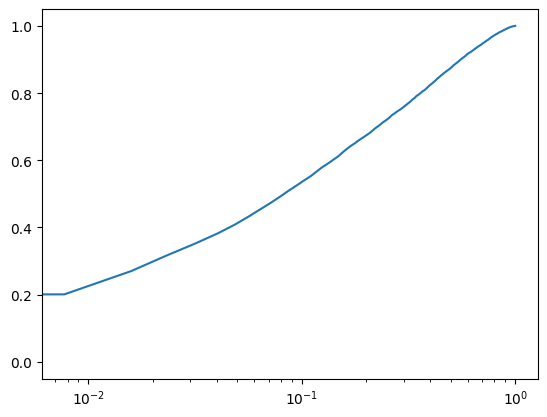

In [66]:
from results.result_processing import print_overall_tpr_at_fpr

df = get_lira_scores(exp_id)
df["rmia_score"] = get_rmia_scores(exp_id)
df["attackr_score"] = get_attackr_scores(exp_id)
print_overall_tpr_at_fpr(df, "attackr_score")

In [5]:
print_overall_tpr_at_fpr(df, "rmia_score")

NameError: name 'df' is not defined

In [6]:
get_rmia_scores(exp_id)

NameError: name 'get_rmia_scores' is not defined

In [122]:
get_tpr_fpr_attack_comparison(1, exp_id, k, [0.001], "precision")

target_col='lira_score'base_col='final loss'

[0.      0.      0.      ... 0.99992 0.99996 1.     ] [0.e+00 4.e-05 8.e-05 ... 1.e+00 1.e+00 1.e+00] THRESHOLD= 80.22825110593342
target_col='lira_score'base_col='loss iqr (75%-25%)'

[0.      0.      0.      ... 0.99992 0.99996 1.     ] [0.e+00 4.e-05 8.e-05 ... 1.e+00 1.e+00 1.e+00] THRESHOLD= 80.22825110593342
target_col='lira_score'base_col='attackr_score'

[0.      0.      0.      ... 0.99992 0.99996 1.     ] [0.e+00 4.e-05 8.e-05 ... 1.e+00 1.e+00 1.e+00] THRESHOLD= 80.22825110593342
target_col='lira_score'base_col='rmia_score'

[0.      0.      0.      ... 0.99992 0.99996 1.     ] [0.e+00 4.e-05 8.e-05 ... 1.e+00 1.e+00 1.e+00] THRESHOLD= 80.22825110593342
target_col='lira_score'base_col='random_guessing'

[0.      0.      0.      ... 0.99992 0.99996 1.     ] [0.e+00 4.e-05 8.e-05 ... 1.e+00 1.e+00 1.e+00] THRESHOLD= 80.22825110593342


{'lira_score': {'final loss': array([0.168]),
  'loss iqr (75%-25%)': array([0.724]),
  'attackr_score': array([0.656]),
  'rmia_score': array([0.56]),
  'random_guessing': array([0.17372])}}

<Figure size 640x480 with 0 Axes>

In [17]:
k=1
levels = np.logspace(-5, 0, 100)
precision_dict = get_tpr_fpr_attack_comparison(1, exp_id, k, levels, "precision")
recall_dict = get_tpr_fpr_attack_comparison(1, exp_id, k, levels, "recall")

file = f"precision_dict_log_{exp_id}.json"
with open(file, 'w') as f: 
    json.dump(precision_dict, f, cls=NumpyEncoder)

file = f"recall_dict_log_{exp_id}.json"
with open(file, 'w') as f: 
    json.dump(recall_dict, f, cls=NumpyEncoder)

k=1
levels = np.linspace(0, 1, 100)
print(exp_id)
precision_dict = get_tpr_fpr_attack_comparison(1, exp_id, k, levels, "precision")
recall_dict = get_tpr_fpr_attack_comparison(1, exp_id, k, levels, "recall")

file = f"precision_dict_lin_{exp_id}.json"
with open(file, 'w') as f: 
    json.dump(precision_dict, f, cls=NumpyEncoder)

file = f"recall_dict_lin_{exp_id}.json"
with open(file, 'w') as f: 
    json.dump(recall_dict, f, cls=NumpyEncoder)

# with open(file, 'r') as f:
#     precision_dict = json.load(f)

target_col='lira_score'base_col='final loss'

target_col='lira_score'base_col='loss iqr (75%-25%)'

target_col='lira_score'base_col='attackr_score'

target_col='lira_score'base_col='rmia_score'

target_col='lira_score'base_col='random_guessing'

target_col='lira_score'base_col='final loss'

target_col='lira_score'base_col='loss iqr (75%-25%)'

target_col='lira_score'base_col='attackr_score'

target_col='lira_score'base_col='rmia_score'

target_col='lira_score'base_col='random_guessing'

WRN40_4_CIFAR100
target_col='lira_score'base_col='final loss'

target_col='lira_score'base_col='loss iqr (75%-25%)'

target_col='lira_score'base_col='attackr_score'

target_col='lira_score'base_col='rmia_score'

target_col='lira_score'base_col='random_guessing'

target_col='lira_score'base_col='final loss'

target_col='lira_score'base_col='loss iqr (75%-25%)'

target_col='lira_score'base_col='attackr_score'

target_col='lira_score'base_col='rmia_score'

target_col='lira_score'base_col='random_guessing'


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [15]:
precision_dict["lira_score"]["attackr_score"]

array([0.   , 0.   , 0.   , 0.184, 0.332, 0.444, 0.52 , 0.584, 0.664,
       0.696, 0.736, 0.784, 0.804, 0.836, 0.848, 0.868, 0.88 , 0.892,
       0.904, 0.904, 0.904, 0.904, 0.904, 0.908, 0.908, 0.908, 0.908,
       0.908, 0.912, 0.912, 0.912, 0.912, 0.912, 0.912, 0.912, 0.912,
       0.916, 0.916, 0.916, 0.916, 0.916, 0.916, 0.916, 0.916, 0.916,
       0.916, 0.916, 0.916, 0.916, 0.916, 0.916, 0.916, 0.916, 0.916,
       0.916, 0.928, 0.932, 0.932, 0.932, 0.936, 0.936, 0.944, 0.948,
       0.952, 0.956, 0.96 , 0.96 , 0.96 , 0.96 , 0.96 , 0.964, 0.964,
       0.964, 0.968, 0.968, 0.968, 0.972, 0.972, 0.976, 0.976, 0.976,
       0.984, 0.988, 0.992, 0.992, 0.996, 0.996, 0.996, 0.996, 0.996,
       0.996, 0.996, 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   ])

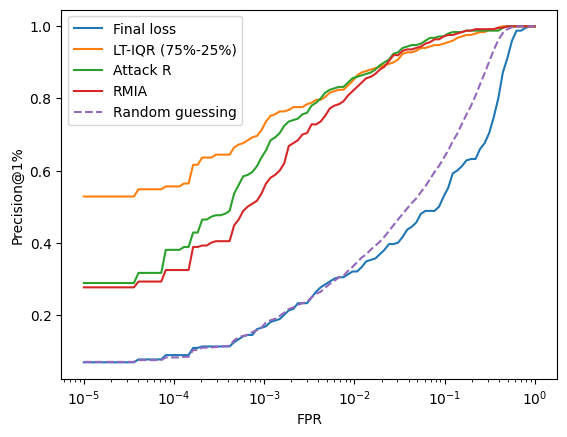

In [110]:
k = 1
log=True
with open(f"precision_dict_log_{exp_id}.json", 'r') as f:
    precision_dict = json.load(f)
metric_dict = precision_dict
levels = np.logspace(-5, 0, 100) if log else np.linspace(0, 1, 100)

for target_col, v in metric_dict.items():
    for base_col, vals in v.items():
        if target_col != base_col:
            if base_col == "random_guessing":
                plt.plot(levels, vals, '--', label=label_mapping[base_col])
            else:
                plt.plot(levels, vals, label=label_mapping[base_col])
        # break
    plt.xlabel("FPR")
    plt.ylabel(f"{metric.capitalize()}@{k}%")
    plt.legend()
    # [p + f"{label}" for p in avg_norm_plots for k in ks]
    # plt.axvline(x = 0.001, color = 'b', label = 'axvline - full height')
    if log:
        plt.xscale('log')
        
    # plt.ylim((0,0.5))
    l = "log" if log else "lin"
    plt.savefig(f"./{metric}@{k}_{target_col}_fpr_{l}_{exp_id}.pdf", bbox_inches='tight')
    plt.show()    


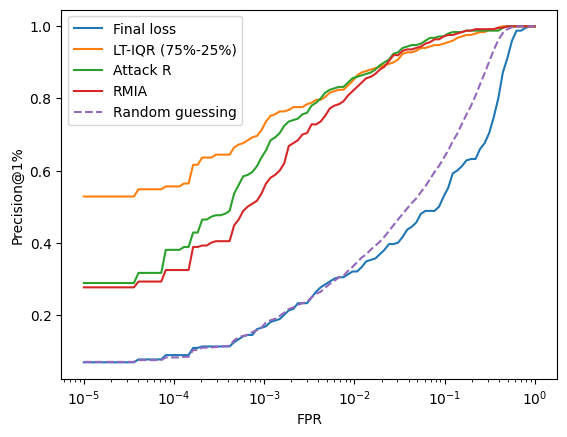

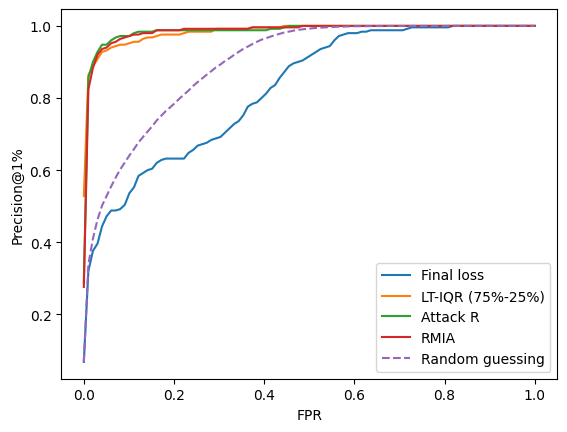

In [76]:
import json
with open(f"precision_dict_log_{exp_id}.json", 'r') as f:
    precision_dict = json.load(f)
plot_tpr(metric="precision", metric_dict=precision_dict, log=True)
with open(f"precision_dict_lin_{exp_id}.json", 'r') as f:
    precision_dict = json.load(f)
plot_tpr(metric="precision", metric_dict=precision_dict, log=False)

In [42]:
exp_id

'WRN40_4_CIFAR100'

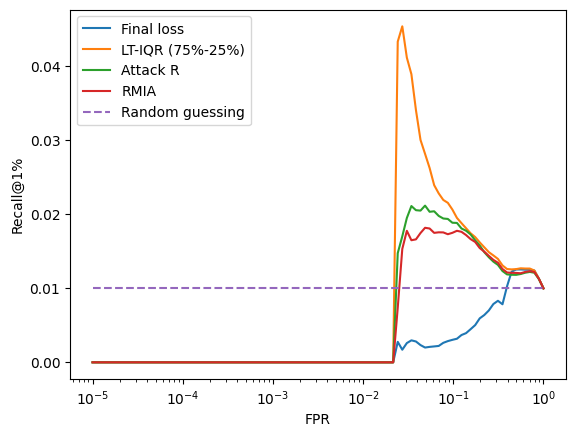

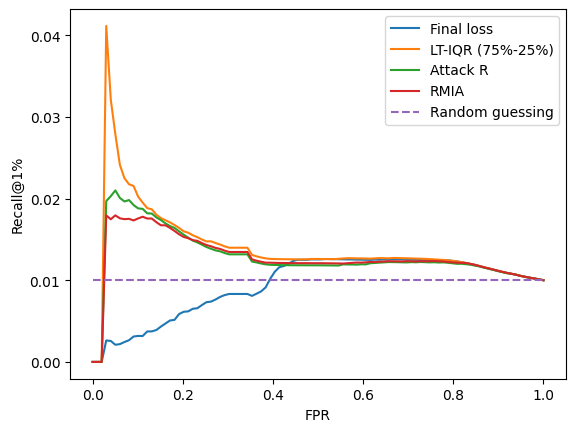

In [29]:
with open(f"recall_dict_log_{exp_id}.json", 'r') as f:
    recall_dict = json.load(f)
plot_tpr(metric="recall", metric_dict=recall_dict, log=True)
with open(f"recall_dict_lin_{exp_id}.json", 'r') as f:
    recall_dict = json.load(f)
plot_tpr(metric="recall", metric_dict=recall_dict, log=False)

In [60]:

plots = [
    # ("attackr_score", None),
    (
    'loss attack',
    lambda exp_id, t_id: -get_avg_loss(exp_id, t_id, first=-1)
    ),
    (
    'final loss',
    lambda exp_id, t_id: get_avg_loss(exp_id, t_id, first=-1)
    ),
    (
    'delta/mid',
    lambda exp_id, t_id: get_delta_over_mid_loss(exp_id, t_id, first=0, last=-1)
    ),
    (
    'mean loss',
    lambda exp_id, t_id: get_avg_loss(exp_id, t_id, last=-1)
    ),
    (
    'final - init (loss)',
    lambda exp_id, t_id: get_avg_loss(exp_id, t_id, first=-1) - get_avg_loss(exp_id, t_id, first=0, last=1)
    ),
    (
    'final loss / init loss',
    lambda exp_id, t_id: get_avg_loss(exp_id, t_id, first=-1) / get_avg_loss(exp_id, t_id, last=1)
    ),
    (
    'avg quarter 2 - avg late (loss)',
    lambda exp_id, t_id: get_avg_loss(exp_id, t_id, first=5, last=10) - get_avg_loss(exp_id, t_id, first=-2)
    ),
    (
    'loss iqr (75%-25%)',
    lambda exp_id, t_id: get_loss_iqr(exp_id, t_id, first=0, last=-1)
    ),
    (
    'mid-end',
    lambda exp_id, t_id: get_loss_mid_end(exp_id, t_id, last=-1)
    ),
    (
    '|avg 1st half loss - avg late/final loss|',
    lambda exp_id, t_id: np.abs(get_avg_loss(exp_id, t_id, first=1, last=10) - get_avg_loss(exp_id, t_id, first=-2))
     ),
    (
    'final loss / avg loss',
    lambda exp_id, t_id: get_avg_loss(exp_id, t_id, first=-1) / get_avg_loss(exp_id, t_id, first=0)
     ),
    (
    'loss norm',
    lambda exp_id, t_id: get_loss_norms(exp_id, t_id)
     ),
]

def make_metrics_table(k_metrics, ks, avg_norm_plots):
    # avg_norm_plots =  [x[0] for x in plots]
    # k_metrics = [get_metrics_set_for_k(plots, k, levels, avg_norm_plots) for k in ks]
    
    for i,k_val in enumerate(ks):
        plot_df = k_metrics[i]
        plot_df = pd.DataFrame(np.array(plot_df)[:,:,0])
        plot_df.columns = [f"Accuracy@{i}%", f"Precision@{i}% (FPR={levels[0]})", f"Recall@{i}% (FPR={levels[0]})"]
        # display(plot_df)
        
        plot_df.index = avg_norm_plots
        base_col = plots[0][0]
        target_col = "lira_score"
        f = None
        # mean_overall_tprs = get_dual_average(dual_count, exp_id, target_col, base_col, levels, f, k_val, "overall_tpr")
        # n_tp = get_dual_average(dual_count, exp_id, "lira_scores", "avg_norm", k_val, None, [k_val], "n_points")
    
        # print(f"RESULTS FOR k={k_val}%. Overall TPR@FPR={levels[0]} for LiRA = {mean_overall_tprs[0]:.2f}")
        # print(f"Loss trace predicts {n_tp[0]} points to be vulnerable, ground truth is {n_tp[1]:.0f} vulnerable points")
        display(plot_df)
    # return k_metrics

# make_metrics_table([0.1, 1, 2, 3, 5], [0.001])

In [61]:
ks =  [1, 3, 5]
levels = [0.001]
avg_norm_plots =  [x[0] for x in plots]

# k_metrics = [get_metrics_set_for_k(plots + [("attackr_score", None)], k, levels, avg_norm_plots) for k in ks]
np.save("k_metrics_table.npy", np.array(k_metrics))
k_metrics = np.load('k_metrics_table.npy')
make_metrics_table(k_metrics, ks, avg_norm_plots + [("attackr_score", None)])

,Accuracy@0%,Precision@0% (FPR=0.001),Recall@0% (FPR=0.001)
loss attack,0.0000,0.0004,0.000072
final loss,0.0208,0.0816,0.016787
delta/mid,0.0452,0.1396,0.028896
mean loss,0.1792,0.3576,0.073600
final - init (loss),0.0240,0.0856,0.017579
final loss / init loss,0.0220,0.0816,0.016779
avg quarter 2 - avg late (loss),0.1368,0.3556,0.073081
loss iqr (75%-25%),0.3128,0.6132,0.126901
mid-end,0.1728,0.3924,0.081796
|avg 1st half loss - avg late/final loss|,0.1068,0.2976,0.061457


,Accuracy@1%,Precision@1% (FPR=0.001),Recall@1% (FPR=0.001)
loss attack,0.000533,0.000667,0.000373
final loss,0.076267,0.108800,0.066820
delta/mid,0.084133,0.123067,0.076035
mean loss,0.303067,0.380400,0.235459
final - init (loss),0.067333,0.097600,0.060110
final loss / init loss,0.076667,0.109867,0.067545
avg quarter 2 - avg late (loss),0.220133,0.297600,0.183098
loss iqr (75%-25%),0.387867,0.486933,0.301851
mid-end,0.245467,0.322133,0.200753
|avg 1st half loss - avg late/final loss|,0.180667,0.250933,0.154672


,Accuracy@2%,Precision@2% (FPR=0.001),Recall@2% (FPR=0.001)
loss attack,0.00056,0.00056,0.000541
final loss,0.12200,0.12008,0.123202
delta/mid,0.12248,0.11960,0.122719
mean loss,0.36632,0.36104,0.372127
final - init (loss),0.07632,0.07448,0.076777
final loss / init loss,0.12176,0.11976,0.122797
avg quarter 2 - avg late (loss),0.26600,0.26096,0.267420
loss iqr (75%-25%),0.42736,0.42080,0.434158
mid-end,0.28256,0.27768,0.286871
|avg 1st half loss - avg late/final loss|,0.23296,0.22664,0.232802


In [16]:
plots = [
    # (
    #     'final loss',
    #     lambda exp_id, t_id: get_avg_loss(exp_id, t_id, first=-1)
    # ),
    (
        'loss iqr (75%-25%)',
        lambda exp_id, t_id: get_loss_iqr(exp_id, t_id, first=0, last=-1)
    ),
]
# avg_norm_plots = [x[0] for x in plots]

def plot_tpr_fpr_us_comparison(dual_count, exp_id, ks, levels,metric="precision", log=True):
    avg_norm_plots = [x[0] for x in plots]
    metrics_for_k_dict = {}

    for target_col in ["lira_score"]:
        plt.figure()
        metrics_for_k_dict[target_col] = {}
        
        for idx, base_col in enumerate([x[0] for x in plots]):
            metrics_for_k_dict[target_col][base_col] = {}
            for k_idx, k in enumerate(ks):
                if target_col != base_col:
                    f = None
                    if base_col in avg_norm_plots:
                        f = plots[idx][1]
                    tpr = get_dual_average(dual_count, exp_id, target_col, base_col, levels, f, k, metric)
                    print(k, levels[55], tpr[55])
                    metrics_for_k_dict[target_col][base_col][k] = tpr
                    # print(k, levels[0], tpr[0])
                # if base_col in avg_norm_plots:
                #     label = base_col + f"_{k}"
                # else:
                #     label = target_col
                # plt.stackplot(levels, tpr, alpha=0.5)
                # plt.plot(levels, tpr, alpha=0.5,label=base_col + f"_{k}", color=colors[k_idx])
                # plt.fill_between(levels, tpr)
            
    return metrics_for_k_dict

def plot_metrics_for_k(ks, levels, metrics_for_k_dict, log=True, metric="precision"):
    levels = np.logspace(-5, 0, 100) if log else np.linspace(0,1,100)
    for target_col, v in metrics_for_k_dict.items():
        for base_col, vals in v.items():
            plt.figure(figsize=(10, 6))
            
            # Create colormap
            colors = plt.cm.viridis(np.linspace(0, 1, len(ks)))
            
            # Collect all metrics values first
            metrics_values = []
            k_values = []
            
            # Sort by k value to ensure consistent ordering
            for k_val, metrics in sorted(vals.items()):
                metrics_values.append(metrics)
                k_values.append(k_val)
            
            # Fill the area between zero and the lowest curve
            plt.fill_between(levels, np.zeros_like(levels), metrics_values[0], 
                           color=colors[0],
                           alpha=0.3)
            
            # Fill between consecutive curves
            for i in range(len(metrics_values) - 1):
                plt.fill_between(levels, metrics_values[i], metrics_values[i+1], 
                               color=colors[i],
                               alpha=0.3)
            
            # Plot the lines on top
            for k_idx, (metrics, k) in enumerate(zip(metrics_values, k_values)):
                plt.plot(levels, metrics, 
                        label=f"{label_mapping[base_col]}, k = {k}%", 
                        color=colors[k_idx],
                        linewidth=2)
            
            plt.xlabel("FPR")
            plt.ylabel(f"{metric.capitalize()}@k%")
            plt.legend()
            
            if log:
                plt.xscale('log')
                l = "log"
            else:
                l = "lin"
                
            # plt.grid(True, which="both", ls="-", alpha=0.2)
            plt.grid(False)
            plt.savefig(f"./{metric}@different_ks_{target_col}_fpr_{l}.pdf", 
                       bbox_inches='tight',
                       dpi=300)
            plt.show()


In [13]:
# ks = [0.1, 1, 2, 3, 5]
# levels = np.logspace(-5, 0, 100)
# precision_for_k_dict = plot_tpr_fpr_us_comparison(dual_count, exp_id, ks, levels,metric="precision", log=True)
# 
# file = "precision_for_k_dict_log.json"
# with open(file, 'w') as f: 
#     json.dump(precision_for_k_dict, f, cls=NumpyEncoder)
#     
# ks = [0.1, 1, 2, 3, 5]
# levels = np.linspace(0, 1, 100)
# precision_for_k_dict = plot_tpr_fpr_us_comparison(dual_count, exp_id, ks, levels,metric="precision", log=False)
# 
# file = "precision_for_k_dict_lin.json"
# with open(file, 'w') as f: 
#     json.dump(precision_for_k_dict, f, cls=NumpyEncoder)

0.1 0.005994842503189409 0.724
1 0.005994842503189409 0.724
2 0.005994842503189409 0.6643999999999999
3 0.005994842503189409 0.6257333333333334
5 0.005994842503189409 0.57072
0.1 0.5555555555555556 0.8240000000000001
1 0.5555555555555556 0.9036000000000002
2 0.5555555555555556 0.8980000000000002
3 0.5555555555555556 0.8965333333333332
5 0.5555555555555556 0.8864800000000003


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [13]:
# ks = [0.1, 1, 2, 3, 5]
# levels = np.logspace(-5, 0, 100)
# recall_for_k_dict = plot_tpr_fpr_us_comparison(dual_count, exp_id, ks, levels,metric="recall", log=True)
# 
# file = "recall_for_k_dict_log.json"
# with open(file, 'w') as f: 
#     json.dump(recall_for_k_dict, f, cls=NumpyEncoder)
# 
# ks = [0.1, 1, 2, 3, 5]
# levels = np.linspace(0, 1, 100)
# recall_for_k_dict = plot_tpr_fpr_us_comparison(dual_count, exp_id, ks, levels,metric="recall", log=False)
# 
# file = "recall_for_k_dict_lin.json"
# with open(file, 'w') as f: 
#     json.dump(recall_for_k_dict, f, cls=NumpyEncoder)

0.1 0.005994842503189409 0.0075135230214747675
1 0.005994842503189409 0.0750581215195942
2 0.005994842503189409 0.13779654214415915
3 0.005994842503189409 0.1946030719994626
5 0.005994842503189409 0.2958656520855458
0.1 0.5555555555555556 0.0010264738771016096
1 0.5555555555555556 0.011254894269443117
2 0.5555555555555556 0.02237035533236886
3 0.5555555555555556 0.033500678634752236
5 0.5555555555555556 0.05520781211200856


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

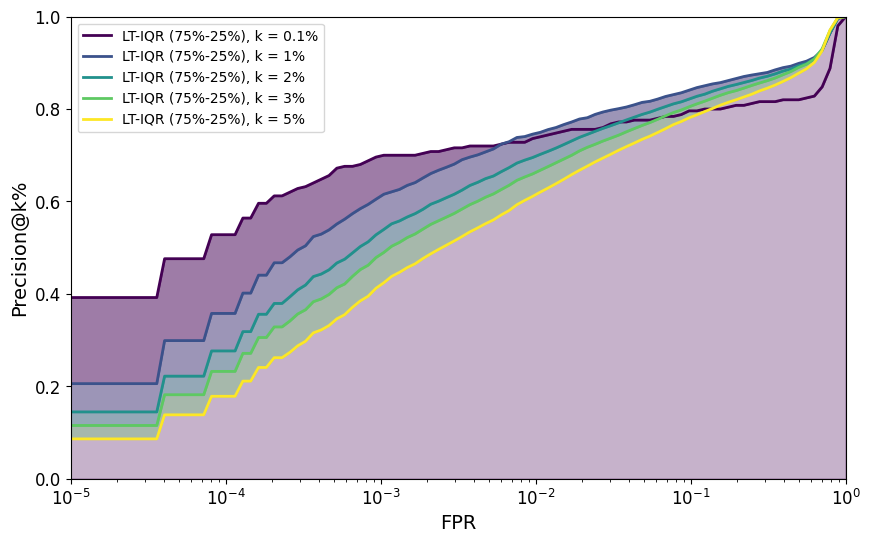

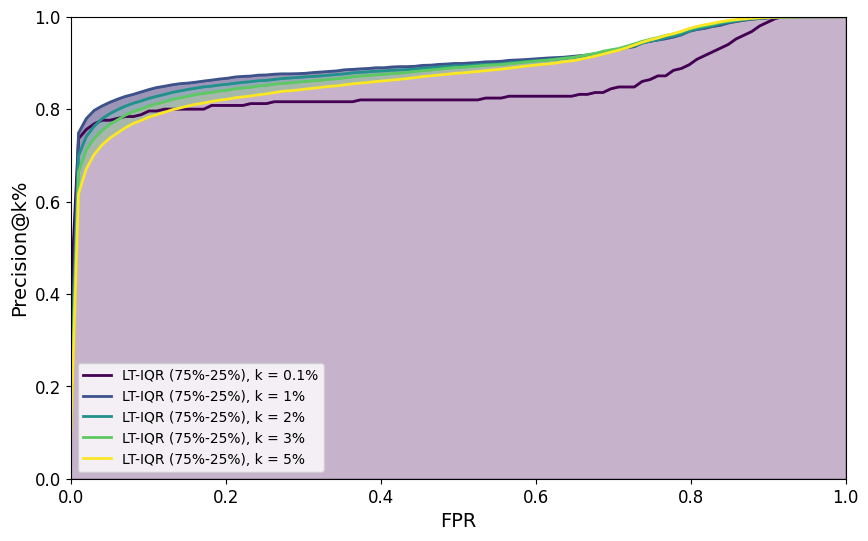

In [17]:
with open("precision_for_k_dict_log.json", 'r') as f:
    precision_for_k_dict = json.load(f)
plot_metrics_for_k(ks,levels,precision_for_k_dict, log=True)

with open("precision_for_k_dict_lin.json", 'r') as f:
    precision_for_k_dict = json.load(f)
plot_metrics_for_k(ks,levels,precision_for_k_dict, log=False)

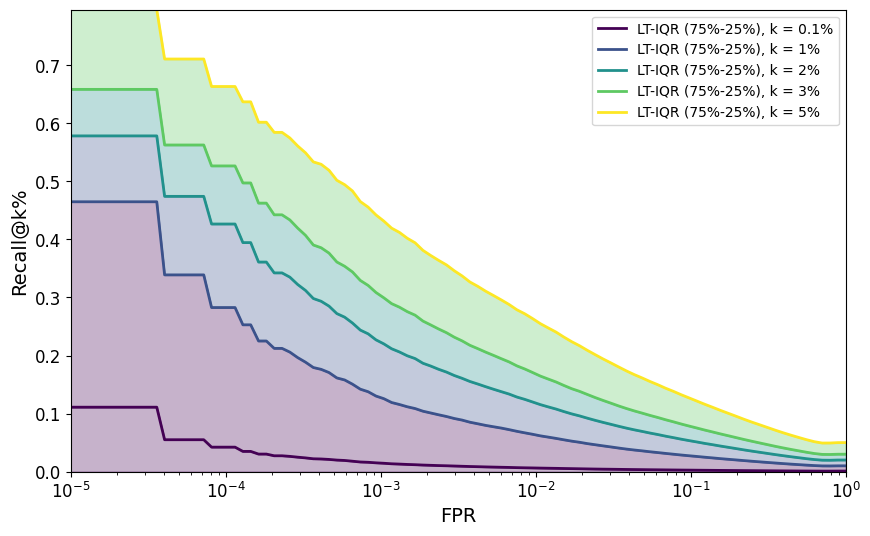

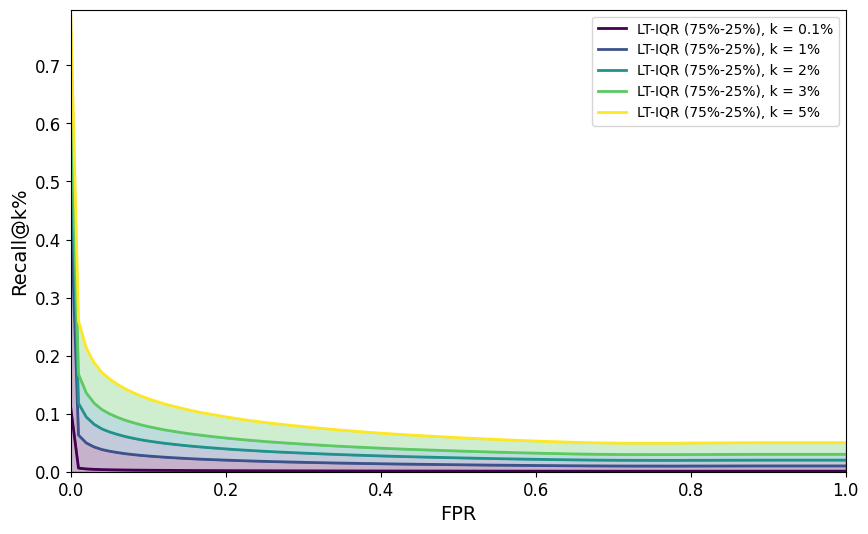

In [18]:
with open("recall_for_k_dict_log.json", 'r') as f:
    recall_for_k_dict = json.load(f)
plot_metrics_for_k(ks,levels,recall_for_k_dict, log=True, metric="recall")

with open("recall_for_k_dict_lin.json", 'r') as f:
    recall_for_k_dict = json.load(f)
plot_metrics_for_k(ks,levels,recall_for_k_dict, log=False, metric="recall")

In [20]:
# def make_metrics_plot(plots, ks, levels):
ks= [0.1, 1, 2, 3, 5]
levels=[0.001]
avg_norm_plots = [x[0] for x in plots]
k_metrics = [get_metrics_set_for_k(plots, k, levels) for k in ks]

for i,k_val in enumerate(ks):
    plot_df = k_metrics[i]
    plot_df = pd.DataFrame(np.array(plot_df)[:,:,0])
    plot_df.columns = [f"Accuracy@{i}%", f"Precision@{i}% (FPR={levels[0]})", f"Recall@{i}% (FPR={levels[0]})"]
    plt.plot(plot_df['Accuracy@{i}%'])

NameError: name 'get_metrics_set_for_k' is not defined

In [14]:
def plot_tpr_fpr_us_comparison(dual_count, exp_id, ks, levels, metric="precision", log=True):
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import numpy as np
    
    avg_norm_plots = [x[0] for x in plots]
    
    for target_col in ["lira_score"]:
        plt.figure(figsize=(10, 6))
        
        # Create colormap
        colors = plt.cm.viridis(np.linspace(0, 1, len(ks)))
        
        for idx, base_col in enumerate([x[0] for x in plots]):
            tpr_values = []  # Store all TPR values to use for filling
            
            # First collect all TPR values
            for k_idx, k in enumerate(ks):
                if target_col != base_col:
                    f = None
                    if base_col in avg_norm_plots:
                        f = plots[idx][1]
                    tpr = get_dual_average(dual_count, exp_id, target_col, base_col, levels, f, k, metric)
                    tpr_values.append(tpr)
            # print(levels, tpr_values)
            # Fill the area between zero and the lowest curve
            plt.fill_between(levels, np.zeros_like(levels), tpr_values[0], 
                           color=colors[0],
                           alpha=0.3)
            
            # Plot fills between consecutive curves
            for i in range(len(ks) - 1):
                plt.fill_between(levels, tpr_values[i], tpr_values[i+1], 
                               color=colors[i],
                               alpha=0.3)
                
            # Plot the lines on top for better visibility
            for k_idx, k in enumerate(ks):
                if base_col in avg_norm_plots:
                    label = base_col + f"_{k}"
                plt.plot(levels, tpr_values[k_idx], 
                        label = f"k={k}%",
                        color=colors[k_idx],
                        linewidth=2)
        
        plt.xlabel("FPR")
        plt.ylabel(f"Precision@k%")
        plt.legend()
        
        if log:
            plt.xscale('log')
            l = "log"
        else:
            l = "lin"
            
        plt.grid(True, which="both", ls="-", alpha=0.2)
        plt.savefig(f"./{metric}@different_ks_filled_{target_col}_fpr_{l}.pdf", 
                   bbox_inches='tight',
                   dpi=300)
        plt.show()

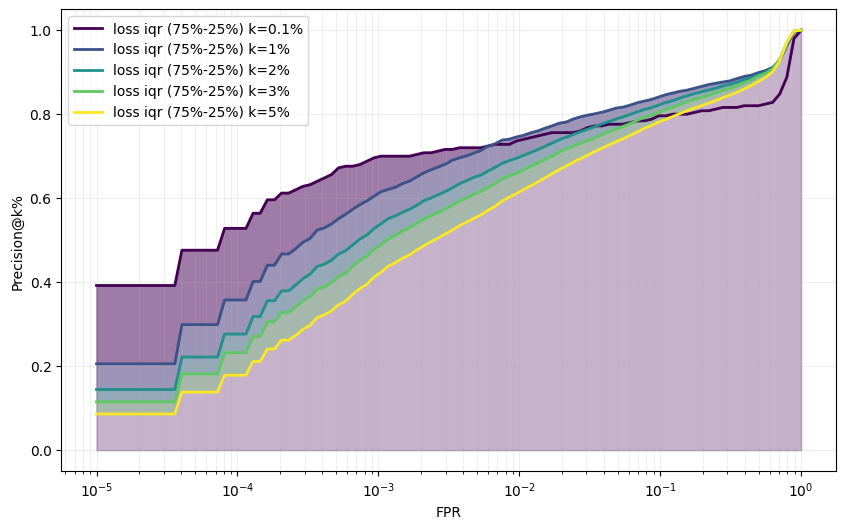

In [15]:
ks = [0.1, 1, 2, 3, 5]
levels = np.logspace(-5, 0, 100)
plot_tpr_fpr_us_comparison(dual_count, exp_id, ks, levels,metric="precision", log=True)

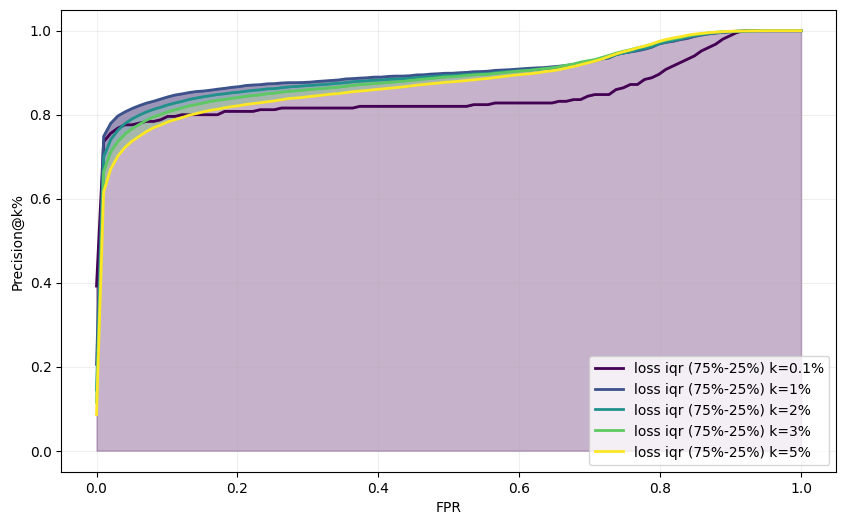

In [16]:
ks = [0.1, 1, 2, 3, 5]
levels = np.linspace(0, 1, 100)
plot_tpr_fpr_us_comparison(dual_count, exp_id, ks, levels,metric="precision", log=False)

In [23]:
for d in range(1): # assuming averaging
    df = get_lira_scores(exp_id)
                         # + "_checkpoint_before_100", f'dual_track_both_{d}')
    # df['avg_norm'] = f(exp_id , f'dual_track_both_{d}') # FROM SRC MODEL
    # df['norm_bin'] = create_bins(df)
    df['attackr_score'] = get_attackr_scores(f'dual_track_both_{d}')
    
    # dual_d_bins = get_results_per_bin(df)
    members = df[df['target_trained_on'] == True]
    top_lira = members.sort_values('lira_score', ascending=False)[:250]
    top_attackr = members.sort_values('attackr_score', ascending=False)
    # top_score = members.sort_values('avg_norm', ascending=False)
            

IndexError: list index out of range